## Ball and beam system modeling via NODEs with interpolated data inputs

In [31]:
using DelimitedFiles, Plots, GZip, StatsBase, LaTeXStrings

We consider the ball and beam system: 

![](https://ctms.engin.umich.edu/CTMS/Content/BallBeam/Simulink/Modeling/figures/bb2.png)

Source: https://ctms.engin.umich.edu/CTMS/index.php?example=BallBeam&section=SimulinkModeling

In the following, we will build a model for the ball dynamics, that is, we want to predict ball position $y(t)=r(t)$ behavior given the input $u(t)=\alpha(t)$. To do so, we are going to download real world data from [DaISy: Database for the Identification of Systems](https://homes.esat.kuleuven.be/~smc/daisy/daisydata.html), in particular the [ball and beam data set](https://ftp.esat.kuleuven.be/pub/SISTA/data/mechanical/ballbeam.txt).

In [32]:
function loaddata(;normalize = true)
    url = "https://ftp.esat.kuleuven.be/pub/SISTA/data/mechanical/ballbeam.dat.gz"
    zipfilename = "C:/Users/Oliver/Downloads/bb.dat.gz"
    path = Base.download(url, zipfilename)

    fh = GZip.open(path)
    data= readdlm(fh)
    u = data[:,1]; # input: beam angle alpha(t)
    y = data[:,2]; # output: ball position r(t)

    dt = Float32(0.1); # sampling time (from data description)

    u = Float32.(u) # convert to Float32 for performance
    y = Float32.(y); # convert to Float32 for performance

    if normalize # optional standardization of data
        dty = fit(ZScoreTransform, y)
        dtu = fit(ZScoreTransform, u)

        y = StatsBase.transform(dty, y)
        u = StatsBase.transform(dtu, u);
    end

    # Further data configuration for later simulation
    NF = Float32 
    datasize = length(y)
    tspan = (zero(NF),NF(1e2))
    tsteps = range(tspan[1], tspan[2]; length=datasize) 

    return u, y, dt, tspan, tsteps
end

loaddata (generic function with 1 method)

As a starting point, we will plot the downloaded ground truth data.

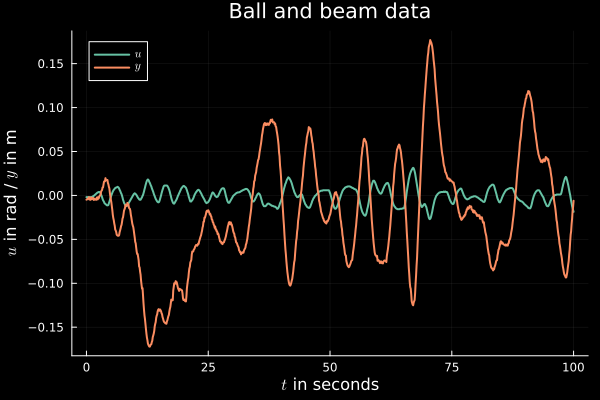

In [33]:
u, y, dt, tspan, tsteps = loaddata(normalize = false)
plot(tsteps, u, label=L"u", title="Ball and beam data", xlabel=L"$t$ in seconds", ylabel=L"$u$ in rad / $y$ in m", 
legend=:topleft, background_color="#000000",lw=2, palette = :Set2_5)
plot!(tsteps, y, label=L"y", lw =2)

As a first attempt, we will use a simple neural ordinary differential equation (NODE) which has only one internal state representation the ball positon: $$\frac{\mathrm{d}}{\mathrm{d}t}\hat{x}(t) = \hat{f}_w(\hat{x}(t), u(t)).$$

In [34]:
using OrdinaryDiffEq, DataInterpolations, Lux, Random, ComponentArrays

As the input data $u(t_k)$ is sampled at discrete time steps $t_k=\{t_1, t_2,\ldots\}$, we are making use of [DataInterpolations.jl](https://github.com/SciML/DataInterpolations.jl) to obtain an interpolation function which represents $u(t)$ in a continuous fashion.  

In [35]:
interp_input = AkimaInterpolation(u, tsteps);

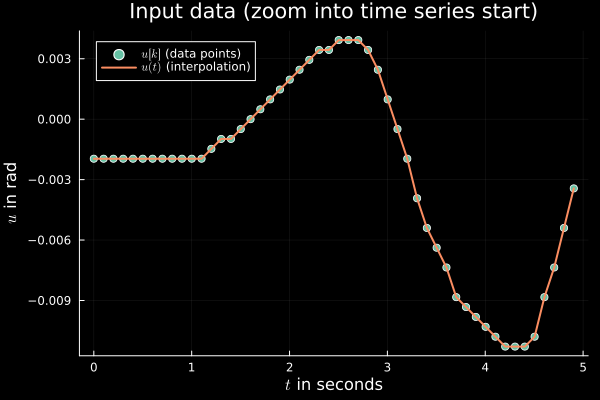

In [36]:
scatter(tsteps[1:50], u[1:50], label=L"$u[k]$ (data points)", title="Input data (zoom into time series start)", xlabel=L"$t$ in seconds", ylabel=L"$u$ in rad", 
legend=:topleft, background_color="#000000",lw=2, palette = :Set2_5)
plot!(tsteps[1:50], interp_input(tsteps[1:50]), label=L"$u(t)$ (interpolation)", lw =2)

We define a simple feedforward ANN as the RHS of the NODE:

In [37]:
ann = Lux.Chain(Lux.Dense(2, 40, tanh), Lux.Dense(40, 1));
p, st =Lux.setup(MersenneTwister(234), ann);
params = ComponentArray(p);

dudt(x, p, t) = ann([x; interp_input(t)], p ,st)[1] # define ODE with single state
u0 = [y[1]] # initialize ODE with first data point
prob = ODEProblem(dudt, u0, tspan, params)

ODEProblem with uType Vector{Float32} and tType Float32. In-place: false
timespan: (0.0f0, 100.0f0)
u0: 1-element Vector{Float32}:
 -0.004885198

Define the usual ODE solver and the quadratic loss function:

In [38]:
function predict_NODE(p)
    Array(solve(prob, Vern7(); u0, p = p, saveat = tsteps, dt, adaptive=false))
end;

In [39]:
function loss_NODE(p)
    pred = predict_NODE(p)
    loss = sum(abs2, y .- pred[1,:])
    return loss
end;

Load required toolboxes for NODE training and define optimization problem.

In [40]:
using SciMLSensitivity, Optimization, OptimizationOptimJL, LineSearches, Zygote

In [41]:
adtype = Optimization.AutoZygote()
optf = Optimization.OptimizationFunction((x, p) -> loss_NODE(x), adtype)
optprob = Optimization.OptimizationProblem(optf, params);

Solve optimization problem using Optim.jl and the BFGS algorithm: 

In [42]:
res = Optimization.solve(optprob,
    BFGS(; initial_stepnorm=0.01, linesearch=LineSearches.BackTracking());
    maxiters=50)

u: ComponentVector{Float32}(layer_1 = (weight = Float32[1.5340279 1.2154727; 1.9060892 2.2610908; … ; -2.3610566 -1.6640711; 0.27005523 0.28591743], bias = Float32[0.023171378; 0.03620469; … ; -0.035825033; 0.0066214143;;]), layer_2 = (weight = Float32[-1.1937464 -0.59527165 … -0.7874022 2.890521], bias = Float32[-0.11490015;;]))

In [43]:
res.original

 * Status: success

 * Candidate solution
    Final objective value:     3.703336e+00

 * Found with
    Algorithm:     BFGS

 * Convergence measures
    |x - x'|               = 0.00e+00 ≤ 0.0e+00
    |x - x'|/|x'|          = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 7.11e-02 ≰ 1.0e-08

 * Work counters
    Seconds run:   29  (vs limit Inf)
    Iterations:    39
    f(x) calls:    79
    ∇f(x) calls:   39


Apparently, the optimization solver converged successfully. Let's investigate the found model by comparing the model's output with the data.

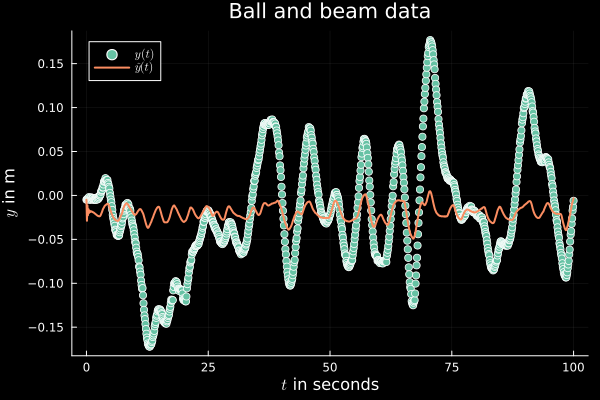

In [44]:
scatter(tsteps, y, label=L"$y(t)$", title="Ball and beam data", xlabel=L"$t$ in seconds", ylabel=L"$y$ in m",
legend=:topleft, background_color="#000000",lw=2, palette = :Set2_5)
plot!(tsteps, predict_NODE(res.u)[1,:], label=L"$\hat{y}(t)$", lw =2)

Obviously, the NODE topology was not suitable to model the ball and beam dynamics. Hence, we need to extend the model scope by incorporating more a priori knowledge. 

Using Newton's mechanics (or a suitable lecture book) while assuming a rather small angle $\alpha(t)$, we can derive the following simple ODE: $$ (\frac{J}{R^2}+m)\ddot{r}(t) = -m g \alpha(t)$$ where $R$, $m$ and $J$ are the ball's radius, mass and inertia as well as $g$ being the gravitational acceleration. Hence, we have a second order ODE which we can rewrite into state-space form as $$\frac{\mathrm{d}}{\mathrm{d} t}\begin{bmatrix}r(t)\\\dot{r(t)}\end{bmatrix} = \begin{bmatrix}\dot{r}(t) \\ -\frac{m g R^2}{J + mR^2} \alpha(t)\end{bmatrix}.$$

Hence, from this excursion into Newton's mechanics we can conclude that our previous single state NODE was insufficient to model the system's dynamics as the input $u(t)=\alpha(t)$ influences the ball speed $\dot{r}(t)$ and not directly $r(t)$, that is, the system has an integral behavior between $u(t)$ and $y(t)$.

Consequently, we will adapt our NODE approach as follows: $$\frac{\mathrm{d}}{\mathrm{d} t}\begin{bmatrix}r(t)\\\dot{r}(t)\end{bmatrix} = \begin{bmatrix}\dot{r}(t) \\ \hat{f}_w(u(t))\end{bmatrix}.$$

In [45]:
u, y, dt, tspan, tsteps = loaddata()
ann = Lux.Chain(Lux.Dense(1, 40, tanh), Lux.Dense(40, 1));
p, st =Lux.setup(MersenneTwister(260921), ann);
params = ComponentArray(p);

dudt(x, p, t) = [x[2]; ann([interp_input(t)], p ,st)[1]] # define ODE with two states
u0 = [y[1]; 0f0] # initialize ODE with first data point and assume zero velocity
prob = ODEProblem(dudt, u0, tspan, params) # define ODE problem

optprob = Optimization.OptimizationProblem(optf, params) # redefine optimization problem


OptimizationProblem. In-place: true
u0: ComponentVector{Float32}(layer_1 = (weight = Float32[0.15221755; -0.041548926; … ; 0.26505306; -0.15437996;;], bias = Float32[0.0; 0.0; … ; 0.0; 0.0;;]), layer_2 = (weight = Float32[0.33544472 0.055147298 … -0.3045641 -0.042380545], bias = Float32[0.0;;]))

In [46]:
res = Optimization.solve(optprob,
    BFGS(; initial_stepnorm=0.01, linesearch=LineSearches.BackTracking());
    maxiters=50)

u: ComponentVector{Float32}(layer_1 = (weight = Float32[0.28882918; -0.019090788; … ; 0.14102411; -0.17164157;;], bias = Float32[-3.654115f-5; 1.8791561f-5; … ; -0.0001766208; 6.301814f-5;;]), layer_2 = (weight = Float32[0.3974266 0.038229078 … -0.19663772 -0.10524272], bias = Float32[-3.454076f-5;;]))

In [47]:
res.original

 * Status: success

 * Candidate solution
    Final objective value:     1.016913e+03

 * Found with
    Algorithm:     BFGS

 * Convergence measures
    |x - x'|               = 1.86e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.41e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 3.91e+00 ≰ 1.0e-08

 * Work counters
    Seconds run:   18  (vs limit Inf)
    Iterations:    21
    f(x) calls:    45
    ∇f(x) calls:   22


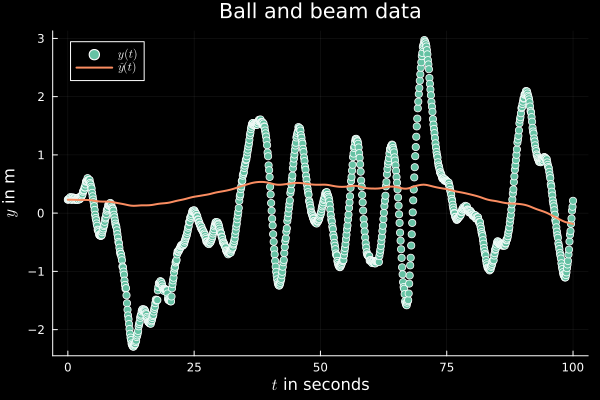

In [48]:
scatter(tsteps, y, label=L"$y(t)$", title="Ball and beam data", xlabel=L"$t$ in seconds", ylabel=L"$y$ in m",
legend=:topleft, background_color="#000000",lw=2, palette = :Set2_5)
plot!(tsteps, predict_NODE(res.u)[1,:], label=L"$\hat{y}(t)$", lw =2)

Unfortunately, the extended NODE model did not perform significantly better than our first attempt. A deeper look into the literature reveals that the above approach via Newton's mechanics is actually too simple and that $\ddot{r}(t)$ is actually depending on $\alpha(t)$ as well as $\dot{\alpha}(t)$ and $\dot{r}(t)$: $$\ddot{r}(t) = f(\alpha(t), \dot{\alpha}(t), \dot{r}(t)).$$

Using a Lagrangian approach to the ball and beam system we can find out the balls' acceleration also depends on the change of the beam angle $\dot{\alpha}(t)$ and the ball's speed $\dot{r}(t)$ (due to friction). Hence, we once again extend the NODE topolgy to $$\frac{\mathrm{d}}{\mathrm{d} t}\begin{bmatrix}\hat{r}(t)\\\hat{\dot{r}}(t)\end{bmatrix} = \begin{bmatrix}\hat{\dot{r}}(t) \\ \hat{f}_w(\alpha(t), \dot{\alpha}(t), \hat{\dot{r}}(t))\end{bmatrix}.$$

Obviously, we require the derivative of the beam angle which is not directly available within the downloaded data. Luckily, we have interpolated the input data with a continuous function such that we can directly get the [derivative](https://docs.sciml.ai/DataInterpolations/stable/interface/#Derivatives) from that function: 

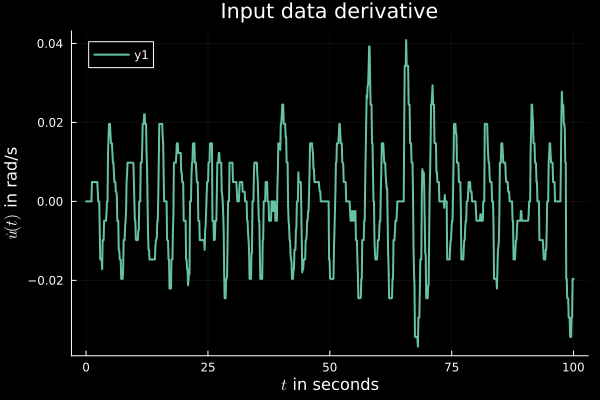

In [49]:
plot(tsteps, map(x -> DataInterpolations.derivative(interp_input, x), tsteps), title = "Input data derivative", xlabel=L"$t$ in seconds", ylabel=L"$\dot{u}(t)$ in rad/s",
legend=:topleft, background_color="#000000",lw=2, palette = :Set2_5)

With the above discussed additional input features we are going to extend the second order NODE model accordingly:

In [50]:
u, y, dt, tspan, tsteps = loaddata(normalize = false) # deactivating normalization for this example
interp_input = QuadraticSpline(u, tsteps); # redo interpolation with quadratic spline
ann = Lux.Chain(Lux.Dense(4, 20, tanh),Lux.Dense(20, 1)); # define neural network with 4 inputs (r, r_dot, u, u_dot) and a single output r_dot_dot
p, st =Lux.setup(MersenneTwister(294), ann);
params = ComponentArray(p);

dudt(x, p, t) = [x[2]; ann([x; interp_input(t); DataInterpolations.derivative(interp_input,t)], p ,st)[1]] # define ODE with two states
u0 = [y[1]; 0f0] # initialize ODE with first data point and assume zero velocity
prob = ODEProblem(dudt, u0, tspan, params) # define ODE problem

optprob = Optimization.OptimizationProblem(optf, params); # redefine optimization problem

In [51]:
res = Optimization.solve(optprob,
    BFGS(; initial_stepnorm=0.01, linesearch=LineSearches.BackTracking());
    maxiters=60)

u: ComponentVector{Float32}(layer_1 = (weight = Float32[0.01009156 -0.19309567 0.21435693 0.17732623; -0.26112038 -0.3788627 -1.0956762 -1.4590849; … ; -0.19631034 -0.64476275 -1.5089114 -2.3130946; -0.25862053 -0.44499412 -0.53309107 -1.9793515], bias = Float32[-0.031438548; 0.06024974; … ; -0.019189041; -0.03842696;;]), layer_2 = (weight = Float32[-1.8788176 1.4850285 … 3.6847568 1.948641], bias = Float32[0.20408086;;]))

In [52]:
res.original

 * Status: success

 * Candidate solution
    Final objective value:     1.886100e+00

 * Found with
    Algorithm:     BFGS

 * Convergence measures
    |x - x'|               = 0.00e+00 ≤ 0.0e+00
    |x - x'|/|x'|          = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 9.39e-01 ≰ 1.0e-08

 * Work counters
    Seconds run:   99  (vs limit Inf)
    Iterations:    45
    f(x) calls:    71
    ∇f(x) calls:   45


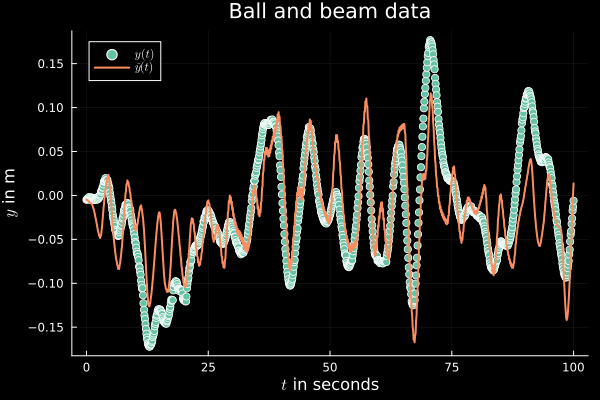

In [53]:
scatter(tsteps, y, label=L"$y(t)$", title="Ball and beam data", xlabel=L"$t$ in seconds", ylabel=L"$y$ in m",
legend=:topleft, background_color="#000000",lw=2, palette = :Set2_5)
plot!(tsteps, predict_NODE(res.u)[1,:], label=L"$\hat{y}(t)$", lw =2)

Although the model fit is certainly not perfect, the physics-driven feature engineering helped to craft a solid starting base to further fine tune the model, e.g, by 
- playing around with further feature engineering, 
- tuning the ODE and optimization solvers' configuration or 
- via a hyperparameter optimization of the NODE's RHS ANN.